The purpose of this notebook is to tune video parameters, such as grayscale, resolution, cropping and sampling, and visualize the accuracy of these adjustments to understand the tradeoffs associated between quality and accuracy in the context of recognizing cars passing in a lane from a traffic video feed. The clip used these adjustments is tcam.mp4.

First, make all necessary imports:

In [1]:
from dlcv.struct import *
from dlcv.utils import *
from dlcv.dataflow.map import *
from dlcv.dataflow.agg import *
from dlcv.tracking.contour import *
from dlcv.tracking.event import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

**Measuring baseline:** We'll first analyze the car count in the left lane. This is the baseline car count (highest quality) using a limit of n frames.

In [24]:
frames = 1000
v = VideoStream('tcam.mp4', limit = frames)
region = Box(200,550,350,750)
pipeline = v[KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
baseCars, stats = count(pipeline, ['one'], stats=True)
print('[Left] Car count is', baseCars['one'])
print('Stats on the analysis:', stats)

[Left] Car count is 16
Stats on the analysis: {'frames': 1001, 'elapsed': 20.226762056350708}


**Cropping:** Let's consider the effect of cropping the area of frame analyzed on overall accuracy. This is a bit subjective to test (as we can crop in infinitely many ways) so the methodology here is to crop relative to the box. Our cropping samples will always be centered around and proportional to the target region.

In [31]:
croppings = np.arange(0, 300, 50)
croppingSizes = []
croppingAccuracies = []

for c in np.nditer(croppings):
    k = KeyPoints()
    x1, y1, x2, y2 = c, c + 350, 550 - c, 1150 - (2*c)
    croppingSizes.append((x2 - x1) * (y2 - y1))
    k.setCrop(Box(x1, y1, x2, y2))
    pipeline = v[k][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    carCount = count(pipeline, ['one'])['one']
    accuracy = carCount / baseCars['one'] if (carCount <= baseCars['one']) else max(carCount - (carCount - baseCars['one']), 0) / baseCars['one'] 
    croppingAccuracies.append(accuracy)

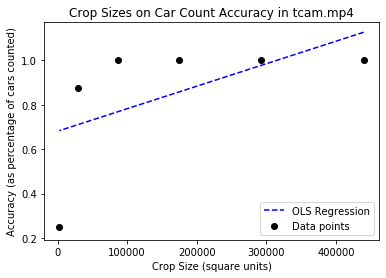

In [45]:
croppingAccuracies = np.asarray(croppingAccuracies)
croppingSizes = np.asarray(croppingSizes).flatten()[:,np.newaxis]
cReg = LinearRegression().fit(croppingSizes, croppingAccuracies)
croppingAccuraciesPred = cReg.predict(croppingSizes)
plt.scatter(croppingSizes, croppingAccuracies, color='black', label='Data points')
plt.plot(croppingSizes, croppingAccuraciesPred, color='blue', linestyle='dashed', linewidth=1.5, label='OLS Regression')
plt.legend(loc='lower right')
plt.title("Crop Sizes on Car Count Accuracy in tcam.mp4")
plt.xlabel('Crop Size (square units)')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()

**Sampling:** Let's consider the effect of only analyzing a specified proportion of frames on overall accuracy.

In [17]:
samplings = np.arange(.05, 1, .05)
samplingReg = samplings[:,np.newaxis]
samplingAccuracies = []
for s in np.nditer(samplings):
    pipeline = v[Sample(s)][KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    samplingAccuracies.append(count(pipeline, ['one'])['one'] / baseCars['one'])

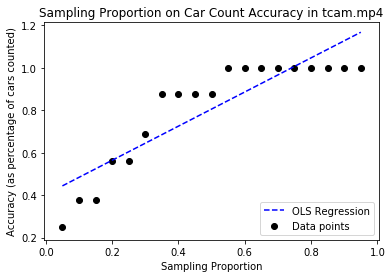

In [18]:
samplingAccuracies = np.asarray(samplingAccuracies)
sReg = LinearRegression().fit(samplingReg, samplingAccuracies)
samplingAccuraciesPred = sReg.predict(samplingReg)
plt.scatter(samplings, samplingAccuracies, color='black', label='Data points')
plt.plot(samplings, samplingAccuraciesPred, color='blue', linestyle='dashed', linewidth=1.5, label='OLS Regression')
plt.legend(loc='lower right')
plt.title("Sampling Proportion on Car Count Accuracy in tcam.mp4")
plt.xlabel('Sampling Proportion')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()

**Grayscale:** Let's consider the effect of changing grayscale on overall accuracy.

**Resolution:** Let's consider the effect of changing the resolution on overall accuracy.

In [56]:
resolutions = np.arange(.5, 1.5, .1)
resolutionReg = resolutions[:,np.newaxis]
resolutionAccuracies = []
for r in np.nditer(resolutions):
    pipeline = v[Resize(r)][KeyPoints()][ActivityMetric('one', region)][Filter('one', [-0.25,-0.25,1,-0.25,-0.25],1.5, delay=10)]
    resolutionAccuracies.append(count(pipeline, ['one'])['one'] / baseCars['one'])

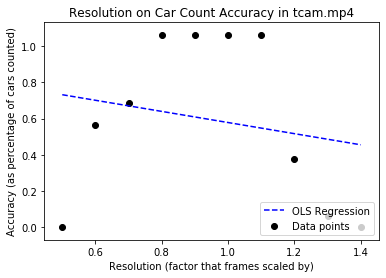

In [57]:
resolutionAccuracies = np.asarray(resolutionAccuracies)
rReg = LinearRegression().fit(resolutionReg, resolutionAccuracies)
resolutionAccuraciesPred = rReg.predict(resolutionReg)
plt.scatter(resolutions, resolutionAccuracies, color='black', label='Data points')
plt.plot(resolutions, resolutionAccuraciesPred, color='blue', linestyle='dashed', linewidth=1.5, label='OLS Regression')
plt.legend(loc='lower right')
plt.title("Resolution on Car Count Accuracy in tcam.mp4")
plt.xlabel('Resolution (factor that frames scaled by)')
plt.ylabel('Accuracy (as percentage of cars counted)')
plt.show()